In [59]:
import polars as pl
import numpy as np
from tqdm import tqdm
from prj.oamp.oamp import OAMP
from prj.oamp.oamp_config import ConfigOAMP
import os, sys, gc
import pickle
import numpy as np
import pandas as pd
import polars as pl

import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_lightning import (LightningDataModule, LightningModule, Trainer)

from sklearn.metrics import r2_score
import kaggle_evaluation.jane_street_inference_server
import torch.optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import math
from tqdm import tqdm
from collections import OrderedDict
import warnings
import joblib
from pytorch_lightning.callbacks import Callback
import gc

import lightgbm as lgb
from lightgbm import LGBMRegressor, Booster
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [60]:
def squared_weighted_error_loss_fn(y_true: np.ndarray, y_pred: np.ndarray, w: np.ndarray) -> np.ndarray:
    return w.reshape(-1, 1) * ((y_true.reshape(-1, 1) - y_pred) ** 2)

def absolute_weighted_error_loss_fn(y_true: np.ndarray, y_pred: np.ndarray, w: np.ndarray) -> np.ndarray:
    return w.reshape(-1, 1) * np.abs(y_true.reshape(-1, 1) - y_pred)

def log_cosh_weighted_loss_fn(y_true: np.ndarray, y_pred: np.ndarray, w: np.ndarray) -> np.ndarray:    
    return w.reshape(-1, 1) * np.log(np.cosh(y_true.reshape(-1, 1) - y_pred))

losses_dict = {
    'mae': absolute_weighted_error_loss_fn,
    'mse': squared_weighted_error_loss_fn,
    'log_cosh': log_cosh_weighted_loss_fn
}

In [61]:
from prj.config import DATA_DIR
from prj.data.data_loader import PARTITIONS_DATE_INFO, DataConfig, DataLoader

data_args = data_args = {'include_time_id': True, 'include_intrastock_norm_temporal': True}
config = DataConfig(**data_args)
loader = DataLoader(data_dir=DATA_DIR, config=config)

start, end = 1360, 1460
test_ds = loader.load(start, end).sort('date_id', 'time_id', 'symbol_id')
features = loader.features
X, y, w, info = loader._build_splits(test_ds)

X.shape

100%|██████████| 108/108 [00:06<00:00, 16.87it/s]


Skipping 1454-1460
Skipping 1455-1460
Skipping 1456-1460
Skipping 1457-1460
Skipping 1458-1460
Skipping 1459-1460
Skipping 1460-1460


(3620320, 134)

# LGBM Agents

In [62]:
import lightgbm as lgb
from lleaves import Model
from pathlib import Path

lgbm_model_files = [
    "/home/lorecampa/projects/jane_street_forecasting/dataset/models/lgbm/lgbm_maxbin_63_0_7_324272949.txt",
    "/home/lorecampa/projects/jane_street_forecasting/dataset/models/lgbm/lgbm_maxbin_63_0_7_3234493111.txt"
]
lgbm_agents = [
    Model(model_file=file) for file in lgbm_model_files
]
for i in tqdm(range(len(lgbm_agents)), desc='Compiling lgbm models'):
    lgbm_agents[i].compile(cache=Path(lgbm_model_files[i]).with_suffix('.o'))


lgbm_agents_label = ['lgbm_1', 'lgbm_2']

Compiling lgbm models: 100%|██████████| 2/2 [00:00<00:00, 14.36it/s]


In [63]:
lgbm_predictions = np.concatenate([agent.predict(X).reshape(-1, 1) for agent in tqdm(lgbm_agents)], axis=1)
lgbm_predictions.shape

100%|██████████| 2/2 [00:13<00:00,  6.68s/it]


(3620320, 2)

In [64]:
del X
gc.collect()

10747

# Graph Conv

In [65]:
import numpy as np
import polars as pl
from pathlib import Path
import gc
import os
from typing import List, Union, Dict, Any

import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torch_geometric.nn import GCNConv

def get_device():
    if torch.cuda.is_available():
        return 'cuda'
    return 'cpu'

class JaneStreetMultiStockGraphDataset(Dataset):
    
    def __init__(self, dataset: pl.LazyFrame, adjacency_matrices: np.ndarray, num_stocks: int = 39):
        self.dataset = dataset
        self.adjacency_matrices = adjacency_matrices
        self.num_stocks = num_stocks
        self.dataset_len = self.dataset.select(['date_id', 'time_id']).unique().collect().shape[0]
        self._load()
    
    def _load(self):
        all_combinations = (
            self.dataset.select(['date_id', 'time_id'])
            .unique()
            .join(pl.DataFrame({'symbol_id': list(range(self.num_stocks))}, 
                               schema={'symbol_id': pl.Int8}).lazy(), how="cross")
        )
        feature_cols = [f'feature_{i:02d}' for i in range(79)]
        self.batch = (
            all_combinations
            .join(self.dataset.with_columns(pl.lit(1).alias('mask')), 
                  on=['date_id', 'time_id', 'symbol_id'], how="left")
            .fill_null(0)  # fill all columns with 0 for missing stocks (including the mask)
            .sort(['date_id', 'time_id', 'symbol_id'])
        )
        # num_stocks rows for each date and time
        self.X = self.batch.select(feature_cols).collect().to_numpy().astype(np.float32)
        self.y = self.batch.select(['responder_6']).collect().to_numpy().flatten().astype(np.float32)
        self.s = self.batch.select(['symbol_id']).collect().to_numpy().flatten().astype(np.int32)
        self.date_ids = self.batch.select(['date_id']).collect().to_numpy().flatten()
        self.masks = self.batch.select(['mask']).collect().to_numpy().flatten() == 0
        self.weights = self.batch.select(['weight']).collect().to_numpy().flatten().astype(np.float32)
    
    def __len__(self):
        return self.dataset_len
    
    def __getitem__(self, idx):
        start_row = idx * self.num_stocks
        features = self.X[start_row:start_row+self.num_stocks, :]
        targets = self.y[start_row:start_row+self.num_stocks]
        masks = self.masks[start_row:start_row+self.num_stocks]
        weights = self.weights[start_row:start_row+self.num_stocks]
        symbols = self.s[start_row:start_row+self.num_stocks]

        date_id = self.date_ids[start_row]
        adj_matrix = self.adjacency_matrices[date_id]
        
        return (
            torch.tensor(features), 
            torch.tensor(targets), 
            torch.tensor(masks), 
            torch.tensor(weights), 
            torch.tensor(symbols),
            torch.tensor(adj_matrix, dtype=torch.int)
        )
        
class WeightedMSELoss(nn.Module):
    def __init__(self):
        super(WeightedMSELoss, self).__init__()
    
    def forward(self, predictions: Tensor, targets: Tensor, weights: Tensor) -> Tensor:
        squared_diff = (predictions - targets) ** 2
        weighted_squared_diff = weights * squared_diff
        return weighted_squared_diff.sum() / weights.sum()
    
class TransposeLayer(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self, input: Tensor) -> Tensor:
        return input.transpose(1, 2)
    
class GraphConvEncoderLayer(nn.Module):
    def __init__(self, hidden_dim, dim_feedforward_mult=4, dropout_rate=0.1):
        super(GraphConvEncoderLayer, self).__init__()
        
        self.graph_conv = GCNConv(
            in_channels=hidden_dim, 
            out_channels=hidden_dim
        )

        self.feedforward = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * dim_feedforward_mult),
            nn.SiLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim * dim_feedforward_mult, hidden_dim)
        )

        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x, edge_index):
        batch_size, num_nodes, num_features = x.size()

        residual = x
        x = x.reshape(batch_size * num_nodes, num_features)
        x = self.graph_conv(x, edge_index)
        x = x.reshape(batch_size, num_nodes, num_features)        
        x = self.dropout1(x) + residual
        x = self.norm1(x)

        residual = x
        x = self.feedforward(x)
        x = self.dropout2(x) + residual
        x = self.norm2(x)

        return x
    

class GraphConvEncoder(nn.Module):
    def __init__(self, hidden_dim, num_layers, dim_feedforward_mult=4, dropout_rate=0.1):
        super(GraphConvEncoder, self).__init__()
        self.layers = nn.ModuleList([
            GraphConvEncoderLayer(
                hidden_dim=hidden_dim,
                dim_feedforward_mult=dim_feedforward_mult,
                dropout_rate=dropout_rate
            ) for _ in range(num_layers)
        ])

    def forward(self, x, adj):
        batch_size, num_nodes, _ = x.size()

        edge_indices = []
        for batch_idx in range(batch_size):
            adj_matrix = adj[batch_idx]
            src, tgt = torch.nonzero(adj_matrix, as_tuple=True)
            src = src + batch_idx * num_nodes
            tgt = tgt + batch_idx * num_nodes
            edge_indices.append(torch.stack([src, tgt], dim=0))

        edge_index = torch.cat(edge_indices, dim=1).to(x.device)
        
        for layer in self.layers:
            x = layer(x, edge_index)
        return x
    

class StockGCNModel(nn.Module):
    def __init__(
        self,
        input_features,
        hidden_dim=64,
        output_dim=1,
        num_layers=2,
        num_stocks=39,
        embedding_dim=16,
        use_embeddings=False,
        dropout_rate=0.2,
        dim_feedforward_mult=4,
    ):
        super(StockGCNModel, self).__init__()

        self.use_embeddings = use_embeddings

        self.init_layers = nn.Sequential(
            # TransposeLayer(),
            # nn.BatchNorm1d(input_features),
            # TransposeLayer(),
            nn.Dropout(dropout_rate),
        )
        self.feature_projector = []
        if use_embeddings:
            self.feature_projector.append(nn.Linear(input_features + embedding_dim, hidden_dim))
            self.embedding_layer = nn.Embedding(num_stocks, embedding_dim)
        else:
            self.feature_projector.append(nn.Linear(input_features, hidden_dim))
        self.feature_projector += [
            # TransposeLayer(),
            # nn.BatchNorm1d(hidden_dim),
            # TransposeLayer(),
            nn.Dropout(dropout_rate),
        ]
        self.feature_projector = nn.Sequential(*self.feature_projector)

        self.encoder = GraphConvEncoder(
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            dim_feedforward_mult=dim_feedforward_mult,
            dropout_rate=dropout_rate
        )

        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            # TransposeLayer(),
            # nn.BatchNorm1d(hidden_dim),
            # TransposeLayer(),
            nn.SiLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, output_dim),
        )

    def forward(self, x, symbols, adj):
        batch_size, num_stocks, num_features = x.size()

        x = self.init_layers(x)
        if self.use_embeddings:
            stock_embeddings = self.embedding_layer(symbols)
            x = torch.cat([x, stock_embeddings], dim=-1)
        x = self.feature_projector(x)
        x = self.encoder(x, adj)

        output = self.predictor(x)
        return 5 * torch.tanh(output)
    
    def predict(self, dl, device):
        with torch.no_grad():
            y_out = []
            for x, targets, m, w, s, A in dl:
                    y_out.append(self(x.to(device), s.to(device), A.to(device)).squeeze().cpu().numpy())
            
            return np.concatenate(y_out)
                
    
def evaluate_model(model, val_dl, device):
    ss_res = 0.0
    ss_tot = 0.0
    for x, targets, m, w, s, A in val_dl:
        with torch.no_grad():
            y_out = model(x.to(device), s.to(device), A.to(device)).squeeze()
        w = w.to(device)
        targets = targets.to(device)
        ss_res += (w * (y_out - targets) ** 2).sum().cpu()
        ss_tot += (w * (targets ** 2)).sum().cpu()
    return 1 - ss_res / ss_tot

In [66]:
adjacency_matrices = np.load('/home/lorecampa/projects/jane_street_forecasting/dataset/sources/graph_conv_torch/adjacency_matrices.npy')

In [67]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

In [68]:

save_path = '/home/lorecampa/projects/jane_street_forecasting/dataset/models/graph_conv/model_3_7.pth'
model = StockGCNModel(
    input_features=79,
    output_dim=1,
    num_layers=1,
    dropout_rate=0.2,
    dim_feedforward_mult=4,
    hidden_dim=64
)
model.load_state_dict(torch.load(save_path, weights_only=True, map_location=torch.device(device)))
model = model.to(device)

graph_conv_models = [model]
graph_conv_agents_label = ['graph_conv_1']

In [69]:
test_dataset = JaneStreetMultiStockGraphDataset(test_ds, adjacency_matrices)
test_dataloader = DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=0)


graph_conv_predictions = model.predict(test_dataloader, device).flatten().reshape(-1, 1)
graph_conv_predictions.shape

(3812952, 1)

# NN

In [70]:
device = 'cuda:0'

class CONFIG:
    """Configuration class for model parameters"""
    seed = 42  # Random seed for reproducibility
    target_col = "responder_6"  # Target variable name
    # Features: 79 base features + 9 lagged features
    feature_cols = [f"feature_{idx:02d}" for idx in range(79)] + [f"responder_{idx}_lag_1" for idx in range(9)]
    # Paths to pre-trained models
    model_paths = [
        "/home/lorecampa/projects/jane_street_forecasting/dataset/sources/nn/model",  # Neural Network models
    ]



def r2_val(y_true, y_pred, sample_weight):
    """
    Calculate weighted R² score
    Args:
        y_true: True values
        y_pred: Predicted values
        sample_weight: Weights for each sample
    Returns:
        Weighted R² score
    """
    r2 = 1 - np.average((y_pred - y_true) ** 2, weights=sample_weight) / (np.average((y_true) ** 2, weights=sample_weight) + 1e-38)
    return r2

class NN(LightningModule):
    """Neural Network model using PyTorch Lightning"""
    
    def __init__(self, input_dim, hidden_dims, dropouts, lr, weight_decay):
        """
        Initialize the neural network
        Args:
            input_dim: Input feature dimension
            hidden_dims: List of hidden layer dimensions
            dropouts: List of dropout rates
            lr: Learning rate
            weight_decay: Weight decay for regularization
        """
        super().__init__()
        self.save_hyperparameters()
        
        # Build network architecture
        layers = []
        in_dim = input_dim
        for i, hidden_dim in enumerate(hidden_dims):
            layers.append(nn.BatchNorm1d(in_dim))  # Batch normalization
            if i > 0:
                layers.append(nn.SiLU())  # SiLU activation (except first layer)
            if i < len(dropouts):
                layers.append(nn.Dropout(dropouts[i]))  # Dropout for regularization
            layers.append(nn.Linear(in_dim, hidden_dim))  # Linear layer
            in_dim = hidden_dim
            
        # Output layer
        layers.append(nn.Linear(in_dim, 1))
        layers.append(nn.Tanh())  # Tanh activation for bounded output
        
        self.model = nn.Sequential(*layers)
        self.lr = lr
        self.weight_decay = weight_decay
        self.validation_step_outputs = []

    def forward(self, x):
        """Forward pass with scaling"""
        return 5 * self.model(x).squeeze(-1)  # Scale output to [-5, 5] range

    def training_step(self, batch):
        """Single training step"""
        x, y, w = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y, reduction='none') * w  # Weighted MSE loss
        loss = loss.mean()
        self.log('train_loss', loss, on_step=False, on_epoch=True, batch_size=x.size(0))
        return loss

    def validation_step(self, batch):
        """Single validation step"""
        x, y, w = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y, reduction='none') * w
        loss = loss.mean()
        self.log('val_loss', loss, on_step=False, on_epoch=True, batch_size=x.size(0))
        self.validation_step_outputs.append((y_hat, y, w))
        return loss

    def on_validation_epoch_end(self):
        """Compute validation metrics at epoch end"""
        if not self.trainer.sanity_checking:
            y = torch.cat([x[1] for x in self.validation_step_outputs]).cpu().numpy()
            prob = torch.cat([x[0] for x in self.validation_step_outputs]).cpu().numpy()
            weights = torch.cat([x[2] for x in self.validation_step_outputs]).cpu().numpy()
            val_r_square = r2_val(y, prob, weights)
            self.log("val_r_square", val_r_square, prog_bar=True, on_step=False, on_epoch=True)
        self.validation_step_outputs.clear()

    def configure_optimizers(self):
        """Configure optimizer and learning rate scheduler"""
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=0.5, 
            patience=5, 
            verbose=True
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
            }
        }

    def on_train_epoch_end(self):
        """Log metrics at end of training epoch"""
        if not self.trainer.sanity_checking:
            epoch = self.trainer.current_epoch
            metrics = {k: v.item() if isinstance(v, torch.Tensor) else v 
                      for k, v in self.trainer.logged_metrics.items()}
            formatted_metrics = {k: f"{v:.5f}" for k, v in metrics.items()}
            print(f"Epoch {epoch}: {formatted_metrics}")

# Load ensemble of models (5-fold cross-validation)
N_folds = 5
nn_models = []
nn_labels = []
for fold in range(N_folds):
    checkpoint_path = f"{CONFIG.model_paths[0]}/nn_{fold}.model"
    nn_model = NN.load_from_checkpoint(checkpoint_path)
    nn_models.append(nn_model.to(device))
    nn_labels.append(f"nn_{fold}")

In [71]:
from prj.data.data_loader import DataLoader as PrjDataLoader
from prj.data.data_loader import DataConfig as PrjDataConfig

data_args = {'include_lags': True}
config = PrjDataConfig(**data_args)
loader = PrjDataLoader(data_dir=DATA_DIR, config=config)


test_ds_nn = loader.load(start-1, end).collect()
test_ds_nn = test_ds_nn.fill_nan(None).with_columns(
    pl.all().forward_fill(limit=10).over('symbol_id').name.keep()
).filter(pl.col('date_id').ge(start)).fill_null(strategy='zero')
test_ds_nn.shape

(3620320, 102)

In [72]:
batch_size = 256  
n_samples = test_ds_nn.shape[0]
n_models = len(nn_models)
nn_predictions = np.zeros((n_samples, n_models))

test_input = test_ds_nn[CONFIG.feature_cols].to_pandas()
test_input = torch.FloatTensor(test_input.values).to(device)

# Generate predictions from Neural Network ensemble
with torch.no_grad():  # Disable gradient calculation for inference
    for i, nn_model in enumerate(nn_models):
        nn_model.eval()  # Set model to evaluation mode
        for start_idx in tqdm(range(0, n_samples, batch_size)):
            end_idx = min(start_idx + batch_size, n_samples)
            batch_input = test_input[start_idx:end_idx]
            batch_predictions = nn_model(batch_input).cpu().numpy()
            nn_predictions[start_idx:end_idx, i] = batch_predictions
        
nn_predictions.shape

100%|██████████| 14142/14142 [00:05<00:00, 2452.68it/s]


(3620320, 5)

In [73]:
del test_ds_nn, test_input
gc.collect()

264

In [76]:
predictions = np.concatenate([nn_predictions, lgbm_predictions], axis=1)
agents = np.concatenate([nn_models, lgbm_agents], axis=0)
agents_label = np.concatenate([nn_labels, lgbm_agents_label], axis=0)

# OAMP

In [74]:
predictions = np.concatenate([nn_predictions, lgbm_predictions], axis=1)
agents = np.concatenate([nn_models, lgbm_agents], axis=0)
agents_label = np.concatenate([nn_labels, lgbm_agents_label], axis=0)

agents_losses = log_cosh_weighted_loss_fn(y, predictions, w)
agents_losses.shape

(3620320, 7)

In [75]:
date_idx_info = pl.DataFrame(info[:, 0], schema=['date_id']).with_row_index().group_by('date_id').agg(
    pl.col('index').min().alias('start'),
    pl.col('index').max().alias('end'),
).sort('date_id').to_numpy()

In [40]:
n_predictions = predictions.shape[0]
days = info[:, 0]

oamp_args = ConfigOAMP({'agents_weights_upd_freq':1, 'loss_fn_window': 1000000, 'agg_type': 'mean'})
n_agents = len(agents)
oamp: OAMP = OAMP(n_agents, oamp_args, agents_label)

y_hat_ens = []

for i, (day, start, end) in enumerate(tqdm(date_idx_info)):
    if i > 0:
        prev_day, prev_start, prev_end = date_idx_info[i-1]
        daily_prev_agents_losses = agents_losses[prev_start:prev_end+1, :]
        oamp.step(daily_prev_agents_losses)
    
    y_hat_ens.append(oamp.compute_prediction(predictions[start:end+1, :]))

    
y_hat_ens = np.concatenate(y_hat_ens)
y_hat_ens.shape

100%|██████████| 41/41 [00:08<00:00,  4.67it/s]


(1458776,)

In [41]:
from sklearn.metrics import r2_score
from prj.metrics import weighted_mae, weighted_mse, weighted_rmse

def metrics(y_true, y_pred, weights):
    return {
        'r2_w': r2_score(y_true, y_pred, sample_weight=weights),
        'mae_w': weighted_mae(y_true, y_pred, weights=weights),
        'mse_w': weighted_mse(y_true, y_pred, weights=weights),
        'rmse_w': weighted_rmse(y_true, y_pred, weights=weights),
    }
    
results = {}
res = metrics(y, y_hat_ens, w)
columns = list(res.keys())
results['ensemble'] = res.values()
for i in range(len(agents_label)):
    results[agents_label[i]] = metrics(y, predictions[:, i], w).values()
results['mean'] = metrics(y, np.mean(predictions, axis=1), w).values()
results['median'] = metrics(y, np.median(predictions, axis=1), w).values()


results = pl.DataFrame(results)\
    .transpose(include_header=True, column_names=columns, header_name='Agent')\
    .sort('r2_w', descending=True) \
    .to_pandas().set_index('Agent')
results

,r2_w,mae_w,mse_w,rmse_w
Agent,,,,
nn_3,0.029964,0.652035,0.990039,0.995007
ensemble,0.029758,0.651609,0.990249,0.995113
nn_4,0.029341,0.651723,0.990675,0.995327
nn_0,0.028997,0.652206,0.991026,0.995503
median,0.027992,0.652116,0.992052,0.996018
mean,0.027303,0.652189,0.992755,0.996371
nn_2,0.026715,0.653197,0.993355,0.996672
nn_1,0.021414,0.654077,0.998766,0.999383
lgbm_2,0.017899,0.654445,1.002353,1.001176


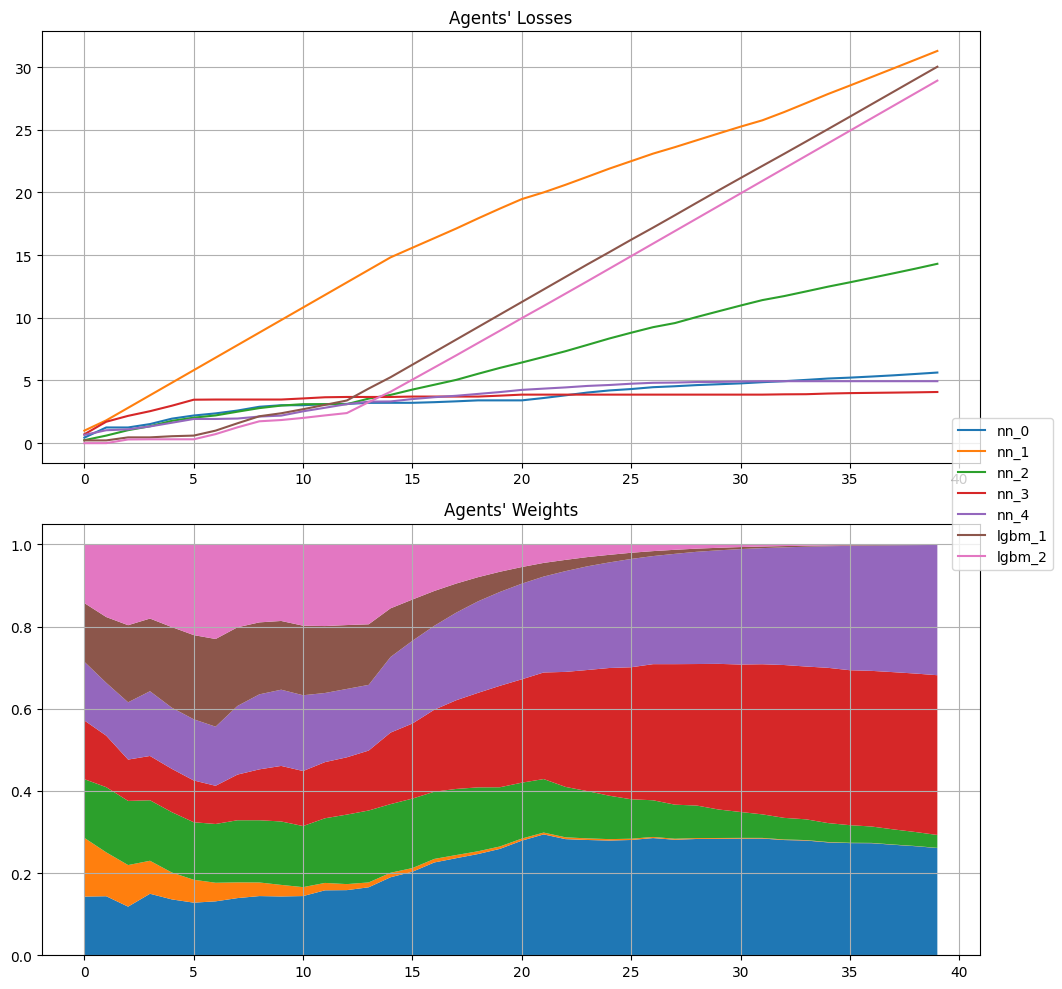

In [42]:
oamp.plot_stats()

In [44]:
predictions.shape

(1458776, 7)

In [50]:
agents_label

array(['nn_0', 'nn_1', 'nn_2', 'nn_3', 'nn_4', 'lgbm_1', 'lgbm_2'],
      dtype='<U6')

In [51]:
pl.DataFrame(predictions, schema=list(agents_label))

nn_0,nn_1,nn_2,nn_3,nn_4,lgbm_1,lgbm_2
f64,f64,f64,f64,f64,f64,f64
0.144011,0.27242,0.213057,0.197513,0.237424,0.412549,0.486029
0.424736,0.387944,0.364205,0.432218,0.462105,0.469783,0.469364
0.253673,0.320909,0.135147,0.398011,0.311266,0.216252,0.23869
-0.034036,0.144055,0.022025,-0.132388,0.198092,0.34706,0.272307
0.210869,0.351395,0.401752,0.287462,0.327083,0.301826,0.346531
…,…,…,…,…,…,…
0.018371,0.006413,0.091394,-0.112561,-0.077134,0.013824,-0.006761
-0.108819,-0.047818,-0.1111,-0.06258,-0.099266,0.019241,0.014849
-0.290974,-0.218671,-0.276055,-0.271185,-0.287478,0.022195,-0.073201


In [57]:
data_args = {'include_time_id': True, 'include_intrastock_norm_temporal': True}
config = PrjDataConfig(**data_args)
loader = PrjDataLoader(data_dir=DATA_DIR, config=config)

train_ds = loader.load(start-100, start-1).sort('date_id', 'time_id', 'symbol_id')

AssertionError: start_dt out of range

In [54]:
# test_ds = test_ds.collect()

test_ds = test_ds.hstack(
    pl.DataFrame(predictions, schema=dict(zip(list(agents_label), [pl.Float32()] * len(agents_label))))
)
test_ds.head()

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,…,feature_74_responder_6_mean,feature_75_responder_6_mean,feature_76_responder_6_mean,feature_77_responder_6_mean,feature_78_responder_6_mean,feature_66_responder_6_std,feature_39_responder_6_std,feature_42_responder_6_std,feature_46_responder_6_std,feature_53_responder_6_std,feature_57_responder_6_std,feature_05_responder_6_skew,feature_40_responder_6_skew,feature_41_responder_6_skew,feature_42_responder_6_skew,feature_43_responder_6_skew,feature_44_responder_6_skew,feature_01_responder_6_zscore,feature_36_responder_6_zscore,feature_40_responder_6_zscore,feature_45_responder_6_zscore,feature_48_responder_6_zscore,feature_49_responder_6_zscore,feature_51_responder_6_zscore,feature_52_responder_6_zscore,feature_53_responder_6_zscore,feature_54_responder_6_zscore,feature_55_responder_6_zscore,feature_59_responder_6_zscore,feature_60_responder_6_zscore,nn_0,nn_1,nn_2,nn_3,nn_4,lgbm_1,lgbm_2
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f64,f64,f64,f64,f64,f64,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1360,0,0,1.865621,2.891473,0.353332,1.668053,2.853531,3.41232,-1.245219,1.179884,0.709263,0.784449,11,7,76,-0.711437,2.205213,0.024286,null,-0.18582,null,-0.776699,-1.427152,-0.106673,-0.18906,1.171838,0.77466,0.049445,0.042497,0.859838,0.686105,0.107406,-0.446071,-0.396082,-0.190675,null,…,null,-0.131318,-0.131088,-0.255547,-0.297823,0.247709,null,null,0.167351,null,0.555311,-0.677584,0.117376,null,null,-0.283499,null,-0.516976,0.60668,-1.12848,-1.414799,-0.725912,0.47003,-0.766313,null,null,-1.246881,null,-1.305083,-1.31452,0.144011,0.27242,0.213057,0.197513,0.237424,0.412549,0.486029
1360,0,1,1.82383,3.157964,0.191611,2.494816,2.845078,3.090568,-0.742658,0.964224,0.692671,1.15839,11,7,76,-0.579026,5.287416,0.753263,null,-0.629359,null,-1.723243,-1.795245,-0.448737,0.015463,0.541579,0.330938,-0.002957,-0.20329,-1.289421,-0.514872,0.273925,-0.443356,-0.530671,0.023403,null,…,null,-0.131318,-0.131088,-0.255547,-0.297823,0.247709,null,null,0.167351,null,0.555311,-0.677584,0.117376,null,null,-0.283499,null,-1.215673,-0.013758,0.275148,0.267192,-0.74132,-0.48033,-0.102595,null,null,-0.610239,null,-0.869856,-0.719961,0.424736,0.387944,0.364205,0.432218,0.462105,0.469783,0.469364
1360,0,2,1.411181,2.71605,0.03601,1.96654,2.863158,2.959575,-1.340717,1.497796,1.125183,1.433874,81,2,59,-0.717919,1.761788,-0.269296,null,-0.376454,null,-2.164926,-1.315706,-0.851814,-0.274073,-0.161511,-0.387801,-0.428675,-0.849509,0.65201,0.264918,-0.209389,-0.984805,-0.524969,-0.219953,null,…,null,2.233127,2.480792,1.619387,1.491205,0.306399,null,null,0.562805,null,0.818506,-0.077942,-0.882023,null,null,-0.029659,null,-1.575562,0.073063,-0.30874,-0.785917,0.242367,1.288985,0.184496,null,null,0.133404,null,-0.09788,0.20247,0.253673,0.320909,0.135147,0.398011,0.311266,0.216252,0.23869
1360,0,3,1.544636,2.70418,0.410197,2.214327,3.090716,3.155712,-0.923788,1.072018,0.611664,0.544632,4,3,11,-1.119727,1.647872,-0.212084,null,-0.119922,null,-0.801926,-1.482203,0.413664,-0.039512,-0.177877,-0.495196,1.19062,2.080005,-0.448234,-0.991314,-0.659872,-0.602899,-0.717945,-0.036078,null,…,null,2.696955,2.790816,0.931928,0.863184,0.35116,null,null,0.568822,null,0.753322,-1.195904,0.248912,null,null,-0.072016,null,-0.302971,1.034766,-0.827462,-1.413804,-0.985616,-0.735671,-1.786559,null,null,-0.471907,null,-0.987755,-1.008498,-0.034036,0.144055,0.022025,-0.132388,0.198092,0.34706,0.272307
1360,0,4,1.061685,